* https://github.com/hill-a/stable-baselines
* https://stable-baselines.readthedocs.io/en/master/

In [1]:
!pip3 install kaggle --upgrade > /dev/null 2>&1

In [2]:
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1

In [3]:
!pip install 'tensorflow-gpu == 1.14.0' > /dev/null 2>&1

In [10]:
!pip install setuptools==65.5.0 pip==21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.
pip-tools 6.13.0 requires pip>=22.2, but you have pip 21.0 which is incompatible.


In [11]:
!pip install stable-baselines3 -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached stable_baselines3-1.8.0-py3-none-any.whl (174 kB)
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  ERROR: Failed building wheel for gym
  Running setup.py clean for gym
Failed to build gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.0
    Uninstalling gym-0.25.0:
      Successfully uninstalled gym-0.25.0
    Running setup.py install for gym ... done
  DEPRECATION: gym was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [37]:
from kaggle_environments import make
import gym
import numpy as np

class ConnectX(gym.Env):
    """Custom Environment that follows gym interface"""

    def __init__(self, opponent_type):
        self.env = make("connectx", debug=True)
        self.trainer = self.env.train([None, opponent_type])
        self.obs = None
        self.action_space = gym.spaces.Discrete(self.env.configuration.columns)
        self.observation_space = gym.spaces.Box(0, 2, shape=(self.env.configuration.rows, self.env.configuration.columns), dtype=np.float32)

    def get_kaggle_env(self):
        return self.env

    def step(self, action):
        # Wrap kaggle environment.step()
        if self.obs[0][action] != 0:
          r = -1 # punish illegal move
          d = False
          o = self.obs
        else:
          o, r, d, _ = self.trainer.step(int(action))
          o = np.reshape(np.array(o['board']), (self.env.configuration.rows, self.env.configuration.columns))
          self.obs = o

        return o, float(r), bool(d), {}

    def reset(self):
        o = self.trainer.reset()
        self.obs = np.reshape(np.array(o['board']), (self.env.configuration.rows, self.env.configuration.columns))
        return self.obs

    def render(self, **kwargs):
        return self.env.render(**kwargs)


In [38]:
import gym

# from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3 import PPO

# from stable_baselines.deepq.policies import MlpPolicy
# from stable_baselines import DQN

from stable_baselines3.common.vec_env import DummyVecEnv

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

# Create log dir
import os
log_dir = "/kaggle/working/"
# os.makedirs(log_dir, exist_ok=True)

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def plot(frame_idx, rewards, mean_rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. mean reward: %s' % (frame_idx, mean_rewards[-1]))
    plt.plot(rewards, color='b')
    plt.plot(mean_rewards, color='y')
#     plt.subplot(132)
#     plt.title('loss')
#     plt.plot(losses)
    plt.show()

rewards = []
mean_rewards = []

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global best_mean_reward, mean_rewards, rewards
    # Evaluate policy training performance
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    if len(x) > 0:
        rewards.append(y[-1])
        mean_reward = np.mean(y[-100:])
        mean_rewards.append(mean_reward)
        plot(x[-1], rewards, mean_rewards)
        print(x[-1], 'timesteps')
        print("Best / last mean reward per episode: {:.2f} / {:.2f}".format(best_mean_reward, mean_reward))

        # New best model, you could save the agent here
        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            # Example for saving best model
            print("*** Saving new best model ***")
            _locals['self'].save(log_dir + 'best_model.pkl')
    return True

best_mean_reward = -1000000

# gym_env = ConnectX('random')
gym_env = ConnectX('negamax')

env = Monitor(gym_env, log_dir, allow_early_resets=True)

env = DummyVecEnv([lambda: env])


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  class ObservationWrapper(Wrapper):


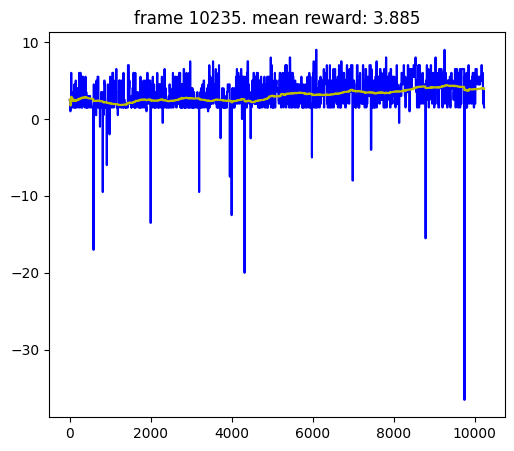

10235 timesteps
Best / last mean reward per episode: 4.40 / 3.88


In [39]:
model = PPO('MlpPolicy', env)
# model = DQN('MlpPolicy', env)

# model.learn(total_timesteps=100000, callback=callback) #, seed=42)
model.learn(total_timesteps=10000, callback=callback) #, seed=42)

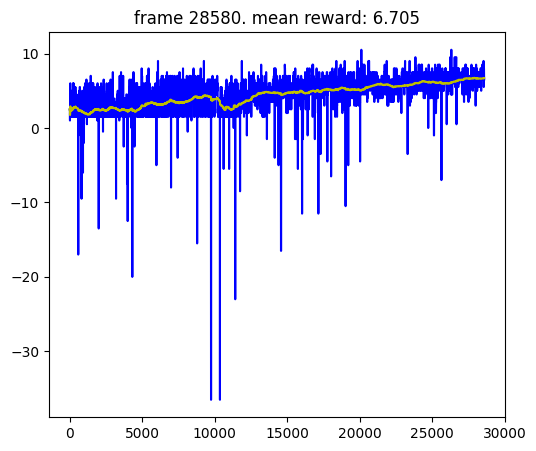

28580 timesteps
Best / last mean reward per episode: 6.74 / 6.71


In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=25000, callback=callback)
model.save("a2c_connectx")

In [18]:
model = PPO.load(log_dir + 'best_model.pkl', env)

done = False
obs = env.reset()
step_cnt = 0

max_moves = gym_env.get_kaggle_env().configuration.columns * gym_env.get_kaggle_env().configuration.rows

while (not done) and step_cnt <= max_moves:
      step_cnt += 1
      action, _states = model.predict(obs, deterministic=True)
      print('action:', action)
      if obs[0][0][action] != 0:
        print('skipping illegal move')
      else:
        obs, reward, done, info = env.step(action)
        gym_env.render()
        print(reward, done)
      print()


action: [0]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 1 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+

[0.5] [False]

action: [5]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 1 | 0 | 0 | 0 | 0 | 1 | 0 |
+---+---+---+---+---+---+---+

[0.5] [False]

action: [5]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 

PyTorch conversion adapted from https://github.com/hill-a/stable-baselines/issues/372

In [19]:
for key, value in model.get_parameters().items():
    print(key, value.shape)

AttributeError: ignored

In [20]:
import torch as th
import torch.nn as nn

class PyTorchMlpPolicy(nn.Module):
    def __init__(self):
        super(PyTorchMlpPolicy, self).__init__()
        self.pi_fc0 = nn.Linear(42, 64)
        self.pi_fc1 = nn.Linear(64, 64)
        self.pi = nn.Linear(64, 7)

        self.tanh = th.tanh
        self.out_activ = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.tanh(self.pi_fc0(x))
        x = self.tanh(self.pi_fc1(x))
        x = self.pi(x)
        x = self.out_activ(x)
        return x

In [21]:
def copy_mlp_weights(baselines_model):
    torch_mlp = PyTorchMlpPolicy()
    model_params = baselines_model.get_parameters()
    # Get only the policy parameters
    policy_keys = [key for key in model_params.keys() if "pi" in key] # or "c" in key]
    policy_params = [model_params[key] for key in policy_keys]

    for (th_key, pytorch_param), key, policy_param in zip(torch_mlp.named_parameters(), policy_keys, policy_params):
        param = policy_param.copy()
        # Copy parameters from stable baselines model to pytorch model

        # weight of fully connected layer
        if len(param.shape) == 2:
            param = param.T

        # bias
        if 'b' in key:
            param = param.squeeze()

        param = th.from_numpy(param)
        pytorch_param.data.copy_(param.data.clone())

    return torch_mlp


In [22]:
th_model = copy_mlp_weights(model)

In [23]:
import torch
from torch.autograd import Variable

episode_reward = 0
done = False
obs = env.reset()
step_cnt = 0
max_moves = gym_env.get_kaggle_env().configuration.columns * gym_env.get_kaggle_env().configuration.rows

while (not done) and step_cnt <= max_moves:
      step_cnt += 1
      th_obs = Variable(torch.from_numpy(obs.flatten()))
      action = th.argmax(th_model(th_obs)).item()

      print('action:', action)
      if obs[0][0][action] != 0:
        print('skipping illegal move')
      else:
        obs, reward, done, info = env.step([action])
        gym_env.render()
        episode_reward += reward
      print()


action: 0
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 1 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+


action: 5
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 1 | 0 | 0 | 0 | 0 | 1 | 0 |
+---+---+---+---+---+---+---+


action: 2
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+-

PyTorch serialization adapted from https://www.kaggle.com/c/connectx/discussion/126678

In [24]:
torch.save(th_model.state_dict(), 'thmodel')

In [25]:
import base64
with open('thmodel', 'rb') as f:
    raw_bytes = f.read()
    encoded_weights = base64.encodebytes(raw_bytes)

In [27]:
print(encoded_weights)

b'UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAdGhtb2RlbC9kYXRhLnBrbEZCDgBaWlpaWlpa\nWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDQAAAHBpX2ZjMC53ZWln\naHRxAmN0b3JjaC5fdXRpbHMKX3JlYnVpbGRfdGVuc29yX3YyCnEDKChYBwAAAHN0b3JhZ2VxBGN0\nb3JjaApGbG9hdFN0b3JhZ2UKcQVYAQAAADBxBlgDAAAAY3B1cQdNgAp0cQhRSwBLQEsqhnEJSypL\nAYZxColoAClScQt0cQxScQ1YCwAAAHBpX2ZjMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLQHRx\nEFFLAEtAhXERSwGFcRKJaAApUnETdHEUUnEVWA0AAABwaV9mYzEud2VpZ2h0cRZoAygoaARoBVgB\nAAAAMnEXaAdNABB0cRhRSwBLQEtAhnEZS0BLAYZxGoloAClScRt0cRxScR1YCwAAAHBpX2ZjMS5i\naWFzcR5oAygoaARoBVgBAAAAM3EfaAdLQHRxIFFLAEtAhXEhSwGFcSKJaAApUnEjdHEkUnElWAkA\nAABwaS53ZWlnaHRxJmgDKChoBGgFWAEAAAA0cSdoB03AAXRxKFFLAEsHS0CGcSlLQEsBhnEqiWgA\nKVJxK3RxLFJxLVgHAAAAcGkuYmlhc3EuaAMoKGgEaAVYAQAAADVxL2gHSwd0cTBRSwBLB4VxMUsB\nhXEyiWgAKVJxM3RxNFJxNXV9cTZYCQAAAF9tZXRhZGF0YXE3aAApUnE4KFgAAAAAcTl9cTpYBwAA\nAHZlcnNpb25xO0sBc1gGAAAAcGlfZmMwcTx9cT1oO0sBc1gGAAAAcGlfZmMxcT59cT9oO0sBc1gC\nAAAAcGlxQH1xQWg7SwFzWAkAAABvdXRfYWN0aXZxQn1xQ2g7SwFzdXNiLlBLBw

In [28]:
import io
import base64
import torch
from torch.autograd import Variable
import random

agent_th_model = PyTorchMlpPolicy()
# encoded_weights =b'gAKKCmz8n ..... [long string]
decoded = base64.b64decode(encoded_weights)
buffer = io.BytesIO(decoded)
agent_th_model.load_state_dict(torch.load(buffer))

<All keys matched successfully>

In [29]:
def my_agent(observation, configuration):
      obs = np.array(observation['board'])
      th_obs = Variable(torch.from_numpy(obs)).float()
      y = agent_th_model(th_obs)
      action = th.argmax(agent_th_model(th_obs)).item()
      if observation.board[action] == 0:
          return action
      else:
          return random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])


In [30]:
kaggle_env = gym_env.get_kaggle_env()
kaggle_env.reset()
kaggle_env.run([my_agent, "negamax"])
kaggle_env.render(mode="ipython", width=500, height=450)

In [31]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 0.6
My Agent vs Negamax Agent: 0.0


In [35]:
import inspect
import os

def write_agent_to_file(file):
#     with open(file, "a" if os.path.exists(file) else "w") as f:
    with open(file, "w") as f:
        f.write('import numpy as np\n')
        f.write('import random\n')
        f.write('import torch as th\n')
        f.write('import torch.nn as nn\n')
        f.write('import io\n')
        f.write('import base64\n')
        f.write('import torch\n')
        f.write('from torch.autograd import Variable\n')

        f.write('class PyTorchMlpPolicy(nn.Module):\n')
        f.write('    def __init__(self):\n')
        f.write('        super(PyTorchMlpPolicy, self).__init__()\n')
        f.write('        self.pi_fc0 = nn.Linear(42, 64)\n')
        f.write('        self.pi_fc1 = nn.Linear(64, 64)\n')
        f.write('        self.pi = nn.Linear(64, 7)\n')
        f.write('        self.tanh = th.tanh\n')
        f.write('        self.out_activ = nn.Softmax(dim=0)\n')
        f.write('    def forward(self, x):\n')
        f.write('        x = self.tanh(self.pi_fc0(x))\n')
        f.write('        x = self.tanh(self.pi_fc1(x))\n')
        f.write('        x = self.pi(x)\n')
        f.write('        x = self.out_activ(x)\n')
        f.write('        return x\n')

        f.write('agent_th_model = PyTorchMlpPolicy()\n')
        f.write('encoded_weights =' + str(encoded_weights) + '\n')
        f.write('decoded = base64.b64decode(encoded_weights)\n')
        f.write('buffer = io.BytesIO(decoded)\n')
        f.write('agent_th_model.load_state_dict(torch.load(buffer))\n')

        f.write(inspect.getsource(my_agent))

write_agent_to_file(log_dir + "submission.py")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
from kaggle_environments import utils
submission = utils.read_file(log_dir + "submission.py")
submission_agent = utils.get_last_callable(submission)
sys.stdout = out

kaggle_env.run([submission_agent, submission_agent])
print("Success!" if kaggle_env.state[0].status == kaggle_env.state[1].status == "DONE" else "Failed...")

kaggle_env.play([submission_agent, None])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Success!


https://www.kaggle.com/c/connectx/leaderboard